In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/DL_data/jpeg'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/DL_data/jpeg/1.3.6.1.4.1.9590.100.1.2.136629875411416072917846237793021656345/1-298.jpg
/content/drive/MyDrive/DL_data/jpeg/1.3.6.1.4.1.9590.100.1.2.299170662711792945709435291453358452246/1-053.jpg
/content/drive/MyDrive/DL_data/jpeg/1.3.6.1.4.1.9590.100.1.2.108002057013111430336727044094025324036/1-156.jpg
/content/drive/MyDrive/DL_data/jpeg/1.3.6.1.4.1.9590.100.1.2.250448208412416972132487433473734655011/2-205.jpg
/content/drive/MyDrive/DL_data/jpeg/1.3.6.1.4.1.9590.100.1.2.250448208412416972132487433473734655011/1-206.jpg
/content/drive/MyDrive/DL_data/jpeg/1.3.6.1.4.1.9590.100.1.2.172820530011510719740927646024129693380/2-172.jpg
/content/drive/MyDrive/DL_data/jpeg/1.3.6.1.4.1.9590.100.1.2.172820530011510719740927646024129693380/1-193.jpg
/content/drive/MyDrive/DL_data/jpeg/1.3.6.1.4.1.9590.100.1.2.313353796513626445325980461400032874723/1-264.jpg
/content/drive/MyDrive/DL_data/jpeg/1.3.6.1.4.1.9590.100.1.2.

In [ ]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 30.0 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow

In [ ]:
!pip install opencv-python

In [ ]:
from keras.models import Model
from keras.layers import Input, GlobalAveragePooling2D, Dense
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
from keras.regularizers import l2
from tensorflow.keras.applications import InceptionV3
import cv2
from skimage.filters import threshold_otsu
from skimage.restoration import wiener
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import exposure
from skimage.restoration import wiener
from skimage.morphology import disk
import pywt
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df_meta= pd.read_csv('/content/drive/MyDrive/DL_data/csv_files/meta.csv')
df_meta.head()

,SeriesInstanceUID,StudyInstanceUID,Modality,SeriesDescription,BodyPartExamined,SeriesNumber,Collection,Visibility,ImageCount
0,1.3.6.1.4.1.9590.100.1.2.117041576511324414842...,1.3.6.1.4.1.9590.100.1.2.229361142710768138411...,MG,ROI mask images,BREAST,1,CBIS-DDSM,1,2
1,1.3.6.1.4.1.9590.100.1.2.438738396107617880132...,1.3.6.1.4.1.9590.100.1.2.195593486612988388325...,MG,ROI mask images,BREAST,1,CBIS-DDSM,1,2
2,1.3.6.1.4.1.9590.100.1.2.767416741131676463382...,1.3.6.1.4.1.9590.100.1.2.257901172612530623323...,MG,ROI mask images,BREAST,1,CBIS-DDSM,1,2
3,1.3.6.1.4.1.9590.100.1.2.296931352612305599800...,1.3.6.1.4.1.9590.100.1.2.109468616710242115222...,MG,ROI mask images,BREAST,1,CBIS-DDSM,1,2
4,1.3.6.1.4.1.9590.100.1.2.436657670120353100077...,1.3.6.1.4.1.9590.100.1.2.380627129513562450304...,MG,ROI mask images,BREAST,1,CBIS-DDSM,1,2


In [ ]:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6775 entries, 0 to 6774
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   SeriesInstanceUID  6775 non-null   object
 1   StudyInstanceUID   6775 non-null   object
 2   Modality           6775 non-null   object
 3   SeriesDescription  6775 non-null   object
 4   BodyPartExamined   6775 non-null   object
 5   SeriesNumber       6775 non-null   int64 
 6   Collection         6775 non-null   object
 7   Visibility         6775 non-null   int64 
 8   ImageCount         6775 non-null   int64 
dtypes: int64(3), object(6)
memory usage: 476.5+ KB


In [ ]:
df_dicom = pd.read_csv('/content/drive/MyDrive/DL_data/csv_files/dicom_info.csv')
df_dicom.head()

,file_path,image_path,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ContentDate,ContentTime,ConversionType,...,SecondaryCaptureDeviceManufacturerModelName,SeriesDescription,SeriesInstanceUID,SeriesNumber,SmallestImagePixelValue,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime
0,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...,NaN,16,16,BREAST,351,20160426,131732.685,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.129308726812851964007...,1,23078,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.271867287611061855725...,214951.0
1,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...,NaN,16,16,BREAST,3526,20160426,143829.101,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.248386742010678582309...,1,0,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.161516517311681906612...,193426.0
2,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...,NaN,16,16,BREAST,1546,20160503,111956.298,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.267213171011171858918...,1,0,ISO_IR 100,20160807.0,DDSM,1.3.6.1.4.1.9590.100.1.2.291043622711253836701...,161814.0
3,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,16,16,BREAST,97,20160503,115347.770,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,32298,ISO_IR 100,20170829.0,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,180109.0
4,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,8,8,Left Breast,3104,20160503,115347.770,WSD,...,MATLAB,NaN,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,0,ISO_IR 100,NaN,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,NaN


In [ ]:
df_dicom.SeriesDescription.unique()

array(['cropped images', 'full mammogram images', nan, 'ROI mask images'],
      dtype=object)

In [ ]:
cropped_images = df_dicom[df_dicom.SeriesDescription=='cropped images'].image_path
cropped_images.head(10)

,image_path
0,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...
3,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...
6,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
7,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
10,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
13,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.236373...
19,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.357008...
21,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.231894...
26,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.281604...
28,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.270732...


In [ ]:
full_mammo = df_dicom[df_dicom.SeriesDescription=='full mammogram images'].image_path
full_mammo.head()

,image_path
1,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...
2,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...
11,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.210396...
12,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.749566...
15,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.987658...


In [ ]:
roi_img = df_dicom[df_dicom.SeriesDescription=='ROI mask images'].image_path
roi_img.head()

,image_path
5,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
8,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
9,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
14,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.236373...
20,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.357008...


In [ ]:
imdir = '/content/drive/MyDrive/DL_data/jpeg'

In [ ]:
cropped_images = cropped_images.replace('CBIS-DDSM/jpeg', imdir, regex=True)
full_mammo = full_mammo.replace('CBIS-DDSM/jpeg', imdir, regex=True)
roi_img = roi_img.replace('CBIS-DDSM/jpeg', imdir, regex=True)

# view new paths
print('Cropped Images paths:\n')
print(cropped_images.iloc[0])
print('Full mammo Images paths:\n')
print(full_mammo.iloc[0])
print('ROI Mask Images paths:\n')
print(roi_img.iloc[0])

Cropped Images paths:

/content/drive/MyDrive/DL_data/jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg
Full mammo Images paths:

/content/drive/MyDrive/DL_data/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg
ROI Mask Images paths:

/content/drive/MyDrive/DL_data/jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/2-270.jpg


In [ ]:
full_mammo_dict = dict()
cropped_images_dict = dict()
roi_img_dict = dict()

for dicom in full_mammo:
    key = dicom.split("/")[6]
    full_mammo_dict[key] = dicom
for dicom in cropped_images:
    key = dicom.split("/")[6]
    cropped_images_dict[key] = dicom
for dicom in roi_img:
    key = dicom.split("/")[6]
    roi_img_dict[key] = dicom

# view keys
next(iter((full_mammo_dict.items())))

('1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849',
 '/content/drive/MyDrive/DL_data/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg')

In [ ]:
mass_train = pd.read_csv('/content/drive/MyDrive/DL_data/csv_files/mass_case_description_train_set.csv')
mass_test = pd.read_csv('/content/drive/MyDrive/DL_data/csv_files/mass_case_description_test_set.csv')

mass_train.head()
print(mass_train.values)
print(mass_test['image file path'][0])

[['P_00001' 3 'LEFT' ...
  'Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.422112722213189649807611434612228974994/1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515/000000.dcm'
  'Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.108268213011361124203859148071588939106/1.3.6.1.4.1.9590.100.1.2.296736403313792599626368780122205399650/000000.dcm'
  'Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.108268213011361124203859148071588939106/1.3.6.1.4.1.9590.100.1.2.296736403313792599626368780122205399650/000001.dcm\n']
 ['P_00001' 3 'LEFT' ...
  'Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.319478999311971442426185353560182990988/1.3.6.1.4.1.9590.100.1.2.359308329312397897125630708681441180834/000000.dcm'
  'Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.188473874511440575807446266233629582526/1.3.6.1.4.1.9590.100.1.2.227955274711225756835838775062793186053/000000.dcm'
  'Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.188

In [ ]:
def fix_image_path(data):
    """correct dicom paths to correct image paths"""
    for index, img in enumerate(data.values):
        img_name = img[11].split("/")[2]
        data.iloc[index,11] = full_mammo_dict[img_name]
        img_name = img[12].split("/")[2]
        data.iloc[index,12] = cropped_images_dict[img_name]
        img_name = img[13].split("/")[2]
        data.iloc[index,13] = roi_img_dict[img_name]

# apply to datasets

fix_image_path(mass_train)
fix_image_path(mass_test)
print(mass_train)

     patient_id  breast_density left or right breast image view  \
0       P_00001               3                 LEFT         CC   
1       P_00001               3                 LEFT        MLO   
2       P_00004               3                 LEFT         CC   
3       P_00004               3                 LEFT        MLO   
4       P_00004               3                RIGHT        MLO   
...         ...             ...                  ...        ...   
1313    P_02033               2                RIGHT        MLO   
1314    P_02079               2                RIGHT         CC   
1315    P_02079               2                RIGHT        MLO   
1316    P_02092               2                 LEFT         CC   
1317    P_02092               2                 LEFT        MLO   

      abnormality id abnormality type                          mass shape  \
0                  1             mass  IRREGULAR-ARCHITECTURAL_DISTORTION   
1                  1             mass  IR

In [ ]:
mass_train = mass_train.rename(columns={'left or right breast': 'left_or_right_breast',
                                           'image view': 'image_view',
                                           'abnormality id': 'abnormality_id',
                                           'abnormality type': 'abnormality_type',
                                           'mass shape': 'mass_shape',
                                           'mass margins': 'mass_margins',
                                           'image file path': 'image_file_path',
                                           'cropped image file path': 'cropped_image_file_path',
                                           'ROI mask file path': 'ROI_mask_file_path'})

mass_train.head(5)

,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,/content/drive/MyDrive/DL_data/jpeg/1.3.6.1.4....,/content/drive/MyDrive/DL_data/jpeg/1.3.6.1.4....,/content/drive/MyDrive/DL_data/jpeg/1.3.6.1.4....
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,/content/drive/MyDrive/DL_data/jpeg/1.3.6.1.4....,/content/drive/MyDrive/DL_data/jpeg/1.3.6.1.4....,/content/drive/MyDrive/DL_data/jpeg/1.3.6.1.4....
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,/content/drive/MyDrive/DL_data/jpeg/1.3.6.1.4....,/content/drive/MyDrive/DL_data/jpeg/1.3.6.1.4....,/content/drive/MyDrive/DL_data/jpeg/1.3.6.1.4....
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,/content/drive/MyDrive/DL_data/jpeg/1.3.6.1.4....,/content/drive/MyDrive/DL_data/jpeg/1.3.6.1.4....,/content/drive/MyDrive/DL_data/jpeg/1.3.6.1.4....
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,/content/drive/MyDrive/DL_data/jpeg/1.3.6.1.4....,/content/drive/MyDrive/DL_data/jpeg/1.3.6.1.4....,/content/drive/MyDrive/DL_data/jpeg/1.3.6.1.4....


In [ ]:
mass_train['mass_shape'] = mass_train['mass_shape'].bfill()
mass_train['mass_margins'] = mass_train['mass_margins'].bfill()

#check null values
mass_train.isnull().sum()

,0
patient_id,0
breast_density,0
left_or_right_breast,0
image_view,0
abnormality_id,0
abnormality_type,0
mass_shape,0
mass_margins,0
assessment,0
pathology,0


In [ ]:
print(f'Shape of mass_train: {mass_train.shape}')
print(f'Shape of mass_test: {mass_test.shape}')

Shape of mass_train: (1318, 14)
Shape of mass_test: (378, 14)


In [ ]:
mass_test = mass_test.rename(columns={'left or right breast': 'left_or_right_breast',
                                           'image view': 'image_view',
                                           'abnormality id': 'abnormality_id',
                                           'abnormality type': 'abnormality_type',
                                           'mass shape': 'mass_shape',
                                           'mass margins': 'mass_margins',
                                           'image file path': 'image_file_path',
                                           'cropped image file path': 'cropped_image_file_path',
                                           'ROI mask file path': 'ROI_mask_file_path'})
mass_test['mass_margins'] = mass_test['mass_margins'].bfill()

#check null values
mass_test.isnull().sum()

,0
patient_id,0
breast_density,0
left_or_right_breast,0
image_view,0
abnormality_id,0
abnormality_type,0
mass_shape,0
mass_margins,0
assessment,0
pathology,0


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
print(mass_train['cropped_image_file_path'].head())

0    /content/drive/MyDrive/DL_data/jpeg/1.3.6.1.4....
1    /content/drive/MyDrive/DL_data/jpeg/1.3.6.1.4....
2    /content/drive/MyDrive/DL_data/jpeg/1.3.6.1.4....
3    /content/drive/MyDrive/DL_data/jpeg/1.3.6.1.4....
4    /content/drive/MyDrive/DL_data/jpeg/1.3.6.1.4....
Name: cropped_image_file_path, dtype: object


In [ ]:
print(mass_train['ROI_mask_file_path'].head())

0    /content/drive/MyDrive/DL_data/jpeg/1.3.6.1.4....
1    /content/drive/MyDrive/DL_data/jpeg/1.3.6.1.4....
2    /content/drive/MyDrive/DL_data/jpeg/1.3.6.1.4....
3    /content/drive/MyDrive/DL_data/jpeg/1.3.6.1.4....
4    /content/drive/MyDrive/DL_data/jpeg/1.3.6.1.4....
Name: ROI_mask_file_path, dtype: object


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(img_path, output_size=(224, 224)):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    img_denoised = cv2.GaussianBlur(img, (5, 5), 0)

    median_filtered = cv2.medianBlur(img_denoised, ksize=3)

    img_equalized = cv2.equalizeHist(median_filtered)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    img_morph = cv2.morphologyEx(img_equalized, cv2.MORPH_OPEN, kernel)

    _, img_thresh = cv2.threshold(img_morph, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    img_resized = cv2.resize(img_thresh, output_size)

    return img, img_denoised, img_equalized, img_morph, img_thresh, img_resized

Full Mammograms:



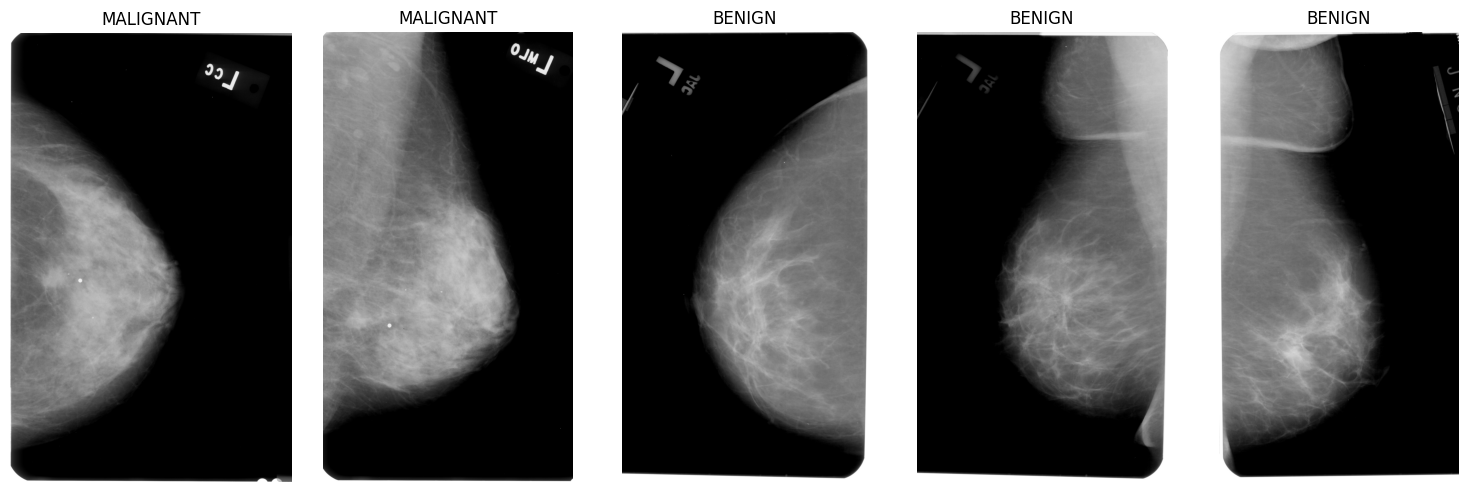

Cropped Mammograms:



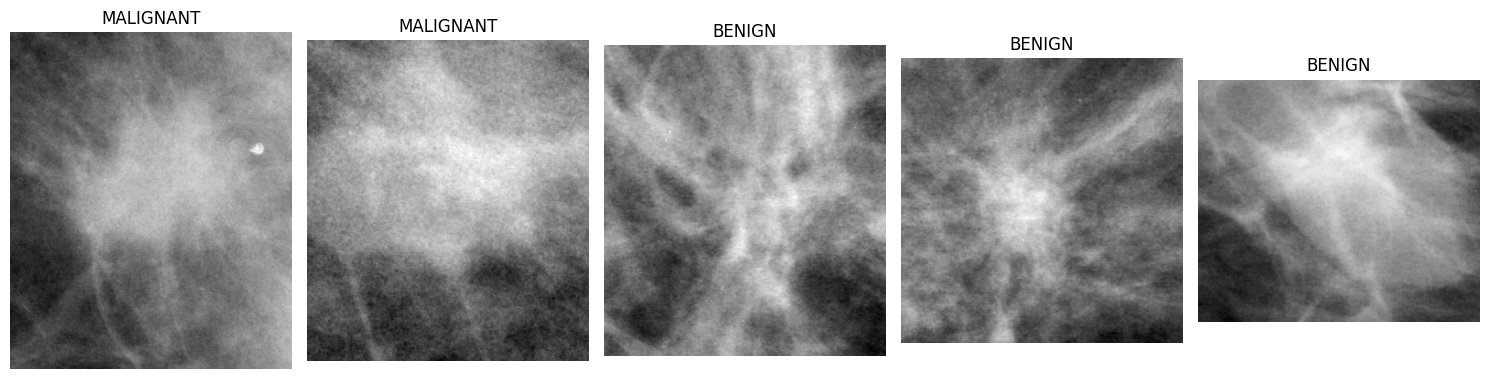

Proccesed imgae:



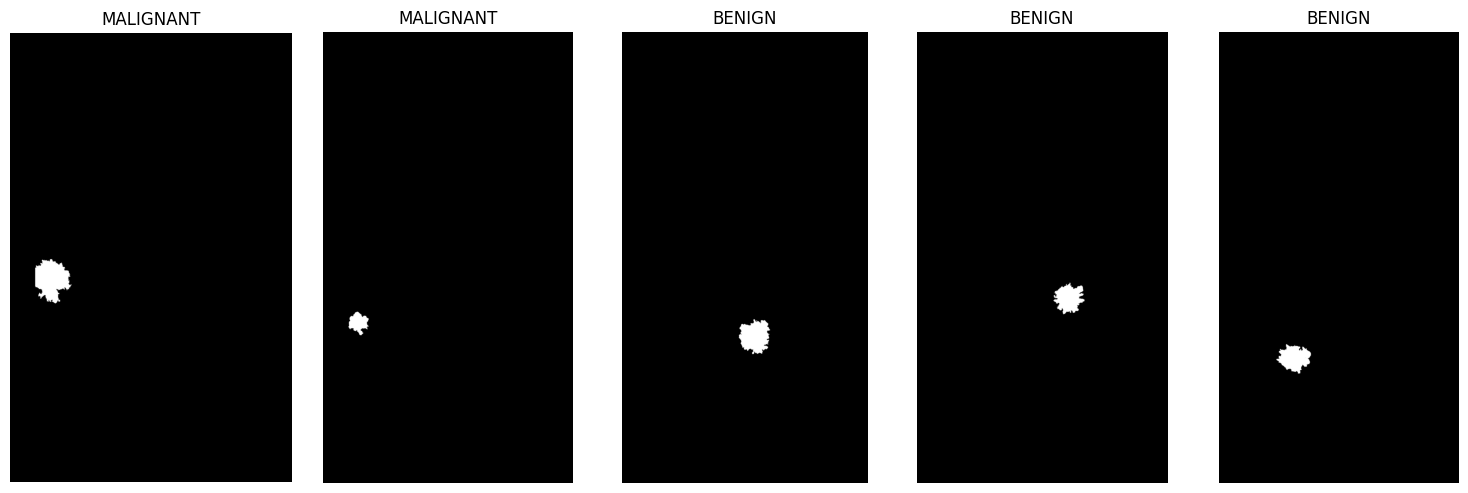

In [ ]:
def display_images(column, number):
    # create figure and axes
    number_to_visualize = number
    rows = 1
    cols = number_to_visualize
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5))

    # Loop through rows and display images
    for index, row in mass_train.head(number_to_visualize).iterrows():
        image_path = row[column]
        image = mpimg.imread(image_path)
        ax = axes[index]
        ax.imshow(image, cmap='gray')
        ax.set_title(f"{row['pathology']}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

print('Full Mammograms:\n')
display_images('image_file_path', 5)
print('Cropped Mammograms:\n')
display_images('cropped_image_file_path', 5)
print('Proccesed imgae:\n')
display_images('ROI_mask_file_path', 5)

In [ ]:
calc_train = pd.read_csv('/content/drive/MyDrive/DL_data/csv_files/calc_case_description_train_set.csv')
calc_test = pd.read_csv('/content/drive/MyDrive/DL_data/csv_files/calc_case_description_test_set.csv')

In [ ]:
print(f'Shape of calc_train: {calc_train.shape}')
print(f'Shape of calc_test: {calc_test.shape}')

Shape of calc_train: (1546, 14)
Shape of calc_test: (326, 14)


In [ ]:
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import cv2
import numpy as np
import os

def image_processor(image_path, target_size):
    """Preprocess images for CNN model, including CLAHE for contrast enhancement"""
    absolute_image_path = os.path.abspath(image_path)


    image = cv2.imread(absolute_image_path)


    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(gray_image)


    image_rgb = cv2.cvtColor(enhanced_image, cv2.COLOR_GRAY2RGB)


    resized_image = cv2.resize(image_rgb, (target_size[1], target_size[0]))


    image_array = resized_image / 255.0

    return image_array

In [ ]:
# Merge datasets
full_mass = pd.concat([mass_train, mass_test], axis=0)

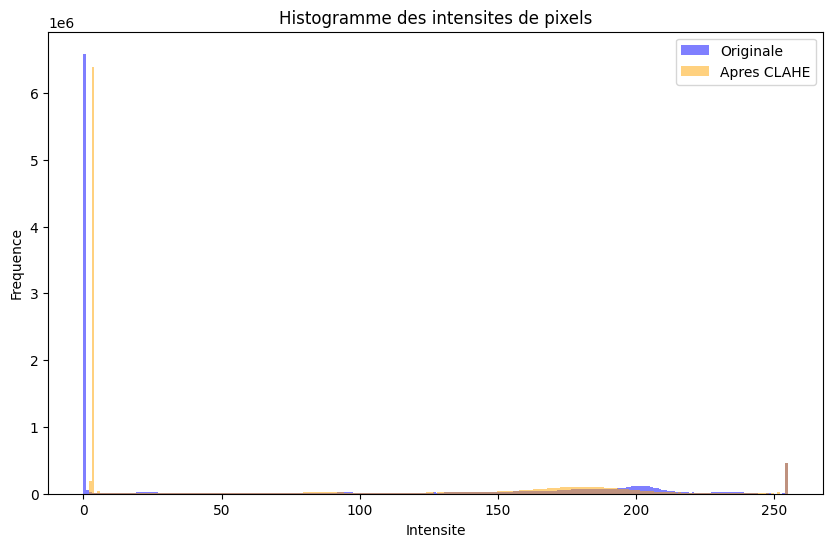

In [ ]:
def evaluate_contrast_enhancement(image_path, target_size):

    original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)


    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(original_image)


    plt.figure(figsize=(10, 6))
    plt.hist(original_image.ravel(), bins=256, alpha=0.5, label='Originale', color='blue')
    plt.hist(enhanced_image.ravel(), bins=256, alpha=0.5, label='Apres CLAHE', color='orange')
    plt.legend()
    plt.title("Histogramme des intensites de pixels")
    plt.xlabel("Intensite")
    plt.ylabel("Frequence")
    plt.show()

# Define the target size
target_size = (224, 224,3)

random_image = full_mass.sample(1)['image_file_path'].values[0]
evaluate_contrast_enhancement(random_image, target_size)

In [ ]:


target_size = (224, 224, 3)


full_mass['processed_images'] = full_mass['image_file_path'].apply(lambda x: image_processor(x, target_size))


class_mapper = {'MALIGNANT': 1, 'BENIGN': 1, 'BENIGN_WITHOUT_CALLBACK': 0}


X_resized = np.array(full_mass['processed_images'].tolist())


full_mass['labels'] = full_mass['pathology'].replace(class_mapper)

num_classes = len(full_mass['labels'].unique())
print(f"Nombre de classes uniques : {num_classes}")


# Split data into train, test, and validation sets (70, 20, 10)
X_train, X_temp, y_train, y_temp = train_test_split(X_resized, full_mass['labels'].values, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
y_val = to_categorical(y_val, num_classes)

<ipython-input-35-a02792cab901>:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  full_mass['labels'] = full_mass['pathology'].replace(class_mapper)


Nombre de classes uniques : 2


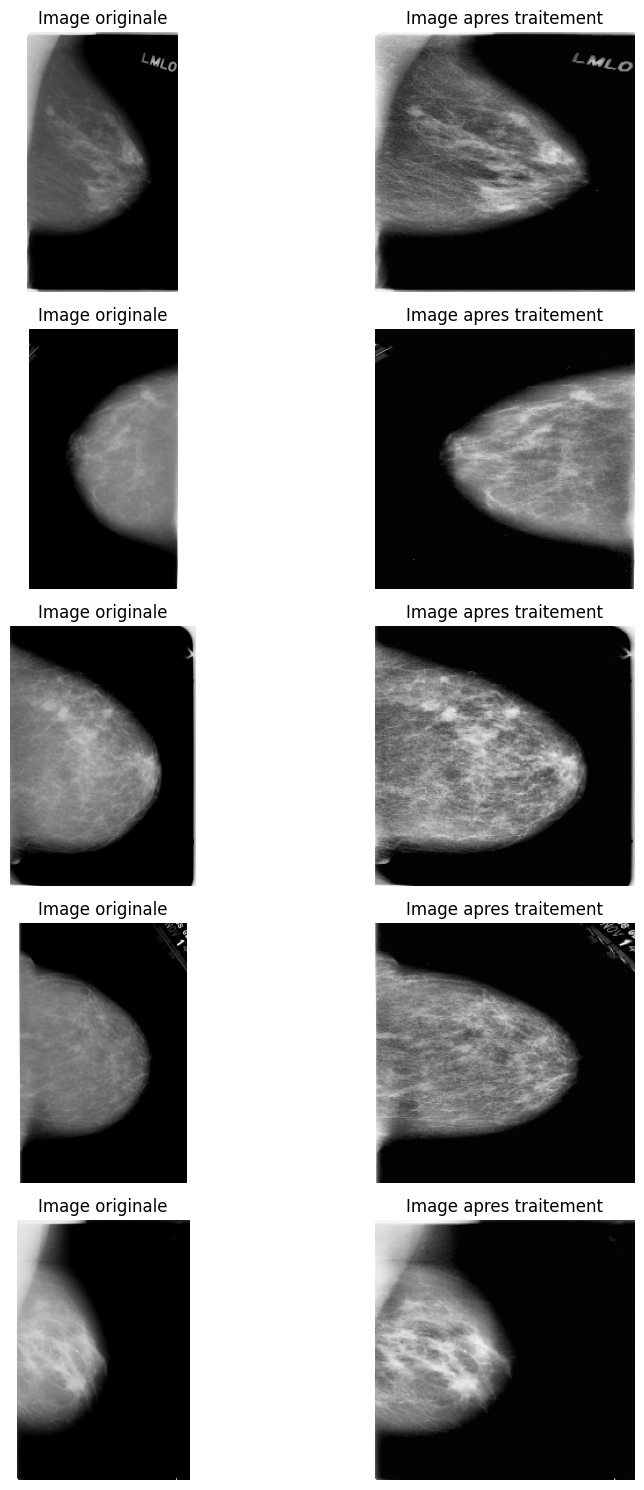

In [ ]:
def display_processed_vs_original(full_mass, num_samples=5):
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 15))


    sample_data = full_mass.sample(num_samples)

    for i, (index, row) in enumerate(sample_data.iterrows()):

        original_image = cv2.imread(row['image_file_path'])
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)


        processed_image = row['processed_images']


        axes[i, 0].imshow(original_image)
        axes[i, 0].set_title("Image originale")
        axes[i, 0].axis("off")


        axes[i, 1].imshow(processed_image)
        axes[i, 1].set_title("Image apres traitement")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()


display_processed_vs_original(full_mass, num_samples=5)

In [ ]:
value_counts = full_mass['labels'].value_counts()
print(value_counts)



labels
1    1555
0     141
Name: count, dtype: int64


"# Création d'un graphique circulaire\nplt.figure(figsize=(8, 6))\nplt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99'])\nplt.title('Repartition des types de masses dans les donnees', fontsize=14)\nplt.show()"

In [ ]:
from sklearn.utils import resample


class_1 = full_mass[full_mass['labels'] == 1]
class_0 = full_mass[full_mass['labels'] == 0]


class_1_downsampled = resample(class_1,
                               replace=False,
                               n_samples=len(class_0),
                               random_state=42)


balanced_full_mass = pd.concat([class_1_downsampled, class_0])


balanced_full_mass = balanced_full_mass.sample(frac=1, random_state=42).reset_index(drop=True)


print(balanced_full_mass['labels'].value_counts())

labels
1    141
0    141
Name: count, dtype: int64


In [ ]:
# Comptage des classes
value_counts = balanced_full_mass['labels'].value_counts()

'''# Création d'un graphique circulaire
plt.figure(figsize=(8, 6))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('Répartition des types de masses dans les données', fontsize=14)
plt.show()'''

"# Création d'un graphique circulaire\nplt.figure(figsize=(8, 6))\nplt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99'])\nplt.title('Répartition des types de masses dans les données', fontsize=14)\nplt.show()"

In [ ]:
# Fonction pour afficher un graphique circulaire pour chaque ensemble
def plot_class_distribution(y_data, title):
    # Comptage des classes
    value_counts = np.sum(y_data, axis=0)  # Somme des colonnes one-hot
    class_labels = [f"Classe {i}" for i in range(len(value_counts))]


plot_class_distribution(y_train, "Répartition des classes - Train")
plot_class_distribution(y_val, "Répartition des classes - Validation")
plot_class_distribution(y_test, "Répartition des classes - Test")


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


X_balanced = np.array(balanced_full_mass['processed_images'].tolist())
y_balanced = balanced_full_mass['labels'].values


X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.15, random_state=42, stratify=y_balanced
)

num_classes = len(np.unique(y_balanced))


print(f"Taille de X_train : {X_train.shape}")
print(f"Taille de y_train : {y_train.shape}")
print(f"Taille de X_test : {X_test.shape}")
print(f"Taille de y_test : {y_test.shape}")

Taille de X_train : (239, 224, 224, 3)
Taille de y_train : (239,)
Taille de X_test : (43, 224, 224, 3)
Taille de y_test : (43,)


In [ ]:
!wget https://storage.googleapis.com/tensorflow/keras-applications/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5

--2025-05-06 18:47:01--  https://storage.googleapis.com/tensorflow/keras-applications/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.203.207, 74.125.199.207, 142.250.99.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.203.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80134624 (76M) [application/octet-stream]
Saving to: ‘vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5.1’

vgg19_weights_tf_di 100%[===================>]  76.42M   163MB/s    in 0.5s    

2025-05-06 18:47:02 (163 MB/s) - ‘vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5.1’ saved [80134624/80134624]



In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.applications import VGG19
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Conv2D, MaxPool2D
from keras import optimizers
from keras import losses
from sklearn import metrics



rows, cols, color = X_train[0].shape
print(f"Taille d'une image d'entrée : {X_train[0].shape}")



base_model = VGG19(
    input_shape=(224, 224, 3),
    weights='vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
    include_top=False
)


model = Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))


for layer in base_model.layers:
    layer.trainable = False


model.summary()


model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=BinaryCrossentropy(),
              metrics=['accuracy'])


history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=10,
                    batch_size=32,
                    verbose=1)


test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")


y_pred = (model.predict(X_test) > 0.5).astype(int)

Taille d'une image d'entrée : (224, 224, 3)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 25088)          │       100,352 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,928,385 (182.83 MB)

 Trainable params: 27,847,681 (106.23 MB)

 Non-trainable params: 20,080,704 (76.60 MB)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 214s 26s/step - accuracy: 0.5087 - loss: 0.9986 - val_accuracy: 0.5116 - val_loss: 1.0246
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 269s 27s/step - accuracy: 0.7648 - loss: 0.4589 - val_accuracy: 0.5116 - val_loss: 0.8958
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 257s 26s/step - accuracy: 0.8791 - loss: 0.2800 - val_accuracy: 0.6279 - val_loss: 0.7597
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 197s 25s/step - accuracy: 0.9310 - loss: 0.2119 - val_accuracy: 0.6512 - val_loss: 0.6821
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 217s 27s/step - accuracy: 0.9416 - loss: 0.1549 - val_accuracy: 0.6279 - val_loss: 0.6549
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 267s 27s/step - accuracy: 0.9879 - loss: 0.0904 - val_accuracy: 0.6279 - val_loss: 0.6509
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 258s 27s/step - accuracy: 0.9906 - loss: 0.0815 - val_accuracy: 0.6512 - val_loss: 0.6067
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 262s 27s/step - accuracy: 0.9882 - loss: 0.0629 - val_accuracy: 0.6744 - val_loss:

In [ ]:
model.save('vgg19.h5')  # or .keras

# Load later
from tensorflow.keras.models import load_model
model = load_model('vgg19.h5')

In [ ]:
# Rapport de classification
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Matrice de confusion
print("\nMatrice de confusion:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.95      0.78        22
           1       0.91      0.48      0.62        21

    accuracy                           0.72        43
   macro avg       0.78      0.72      0.70        43
weighted avg       0.78      0.72      0.70        43


Matrice de confusion:
[[21  1]
 [11 10]]


In [ ]:
!wget https://storage.googleapis.com/tensorflow/keras-applications/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5

--2025-05-06 19:28:36--  https://storage.googleapis.com/tensorflow/keras-applications/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.99.207, 142.250.107.207, 192.178.163.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.99.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58889256 (56M) [application/octet-stream]
Saving to: ‘vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5.1’

vgg16_weights_tf_di 100%[===================>]  56.16M   201MB/s    in 0.3s    

2025-05-06 19:28:37 (201 MB/s) - ‘vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5.1’ saved [58889256/58889256]



In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.applications import VGG16
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from sklearn.metrics import classification_report, confusion_matrix


rows, cols, color = X_train[0].shape
print(f"Taille d'une image d'entrée : {X_train[0].shape}")


from tensorflow.keras.applications import VGG16

base_model = VGG16(
    input_shape=(224, 224, 3),
    weights='vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
    include_top=False
)


model = Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))


for layer in base_model.layers:
    layer.trainable = False


model.summary()


model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=BinaryCrossentropy(),
              metrics=['accuracy'])


history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=10,
                    batch_size=32,
                    verbose=1)


test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")


y_pred = (model.predict(X_test) > 0.5).astype(int)


print("\nClassification Report:")
print(classification_report(y_test, y_pred))


print("\nMatrice de confusion:")
print(confusion_matrix(y_test, y_pred))

Taille d'une image d'entrée : (224, 224, 3)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 25088)          │       100,352 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,618,689 (162.58 MB)

 Trainable params: 27,847,681 (106.23 MB)

 Non-trainable params: 14,771,008 (56.35 MB)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 178s 21s/step - accuracy: 0.6055 - loss: 0.7492 - val_accuracy: 0.5581 - val_loss: 0.6335
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 214s 23s/step - accuracy: 0.8793 - loss: 0.2994 - val_accuracy: 0.7907 - val_loss: 0.5443
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 201s 23s/step - accuracy: 0.9060 - loss: 0.2563 - val_accuracy: 0.8372 - val_loss: 0.4910
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 201s 23s/step - accuracy: 0.9528 - loss: 0.1467 - val_accuracy: 0.8605 - val_loss: 0.4718
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 160s 20s/step - accuracy: 0.9861 - loss: 0.0961 - val_accuracy: 0.8605 - val_loss: 0.4674
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 181s 23s/step - accuracy: 0.9991 - loss: 0.0692 - val_accuracy: 0.8372 - val_loss: 0.4580
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 182s 23s/step - accuracy: 0.9888 - loss: 0.0592 - val_accuracy: 0.8140 - val_loss: 0.4534
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 179s 23s/step - accuracy: 1.0000 - loss: 0.0353 - val_accuracy: 0.8140 - val_loss:

In [ ]:
model.save('vgg16.h5')  # or .keras

# Load later
from tensorflow.keras.models import load_model
model = load_model('vgg16.h5')

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras import regularizers

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

num_classes=1

base_model = Xception(include_top=False,
                     weights="/content/drive/MyDrive/dl/xception_weights_tf_dim_ordering_tf_kernels_notop.h5",
                     input_shape=img_shape,
                     pooling='max')

model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(0.016),
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006),
          activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(num_classes, activation='sigmoid')
])


model.compile(Adamax(learning_rate=0.001),
              loss=BinaryCrossentropy(),
              metrics=['accuracy'])

model.summary()
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=15,
                    batch_size=32,
                    verbose=1)


test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")


y_pred = (model.predict(X_test) > 0.5).astype(int)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,394,473 (81.61 MB)

 Trainable params: 21,335,849 (81.39 MB)

 Non-trainable params: 58,624 (229.00 KB)

Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 282s 31s/step - accuracy: 0.5249 - loss: 27.0149 - val_accuracy: 0.5116 - val_loss: 16.4996
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 243s 28s/step - accuracy: 0.5368 - loss: 10.8775 - val_accuracy: 0.5581 - val_loss: 10.7303
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 264s 29s/step - accuracy: 0.5385 - loss: 9.1729 - val_accuracy: 0.4884 - val_loss: 8.5814
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 259s 28s/step - accuracy: 0.4799 - loss: 8.3717 - val_accuracy: 0.3721 - val_loss: 7.7848
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 229s 28s/step - accuracy: 0.5309 - loss: 7.8139 - val_accuracy: 0.4419 - val_loss: 7.6181
Epoch 6/15


In [ ]:
model.save('xception.h5')  # or .keras

# Load later
from tensorflow.keras.models import load_model
model = load_model('xception.h5')

In [ ]:
import tensorflow as tf
import numpy as np
import time

class MyCallback(tf.keras.callbacks.Callback):
    def __init__(self, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.patience = patience
        self.stop_patience = stop_patience
        self.threshold = threshold
        self.factor = factor
        self.batches = batches
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch
        self.count = 0
        self.stop_count = 0
        self.best_epoch = 1
        self.highest_tracc = 0.0
        self.lowest_vloss = np.inf
        self.ask_permission = 0

    def on_train_begin(self, logs=None):
        self.initial_lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        print('Do you want the model to ask you to halt the training [y/n]?')
        if hasattr(__builtins__, 'input'):
            ans = input('').strip().lower()
            self.ask_permission = 1 if ans == 'y' else 0
        print('{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^10s}{9:^8s}'.format(
            'Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration'))
        self.start_time = time.time()

    def on_train_end(self, logs=None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        print(f'Training elapsed time: {int(hours)} hours, {int(minutes):02} minutes, {seconds:05.2f} seconds')
        self.model.set_weights(self.best_weights)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        acc = logs.get('accuracy', 0.0) * 100
        loss = logs.get('loss', 0.0)
        print(f'Processing batch {batch + 1} of {self.batches} - Accuracy: {acc:.3f} - Loss: {loss:.5f}', end='\r')

    def on_epoch_begin(self, epoch, logs=None):
        self.ep_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        ep_end = time.time()
        duration = ep_end - self.ep_start

        acc = logs.get('accuracy', 0.0)
        v_acc = logs.get('val_accuracy', 0.0)
        loss = logs.get('loss', 0.0)
        v_loss = logs.get('val_loss', 0.0)
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        current_lr = lr

        if acc < self.threshold:
            monitor = 'accuracy'
            pimprov = (acc - self.highest_tracc) * 100 / self.highest_tracc if self.highest_tracc > 0 else 0.0
            if acc > self.highest_tracc:
                self.highest_tracc = acc
                self.best_weights = self.model.get_weights()
                self.count = 0
                self.stop_count = 0
            else:
                self.count += 1
                if self.count >= self.patience:
                    lr *= self.factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr)
                    self.stop_count += 1
                    self.count = 0
        else:
            monitor = 'val_loss'
            pimprov = (self.lowest_vloss - v_loss) * 100 / self.lowest_vloss if self.lowest_vloss < np.inf else 0.0
            if v_loss < self.lowest_vloss:
                self.lowest_vloss = v_loss
                self.best_weights = self.model.get_weights()
                self.count = 0
                self.stop_count = 0
            else:
                self.count += 1
                if self.count >= self.patience:
                    lr *= self.factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr)
                    self.stop_count += 1
                    self.count = 0

        msg = f'{epoch + 1:^3}/{self.epochs:^4} {loss:^9.3f}{acc * 100:^9.2f}{v_loss:^9.5f}{v_acc * 100:^9.2f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count >= self.stop_patience:
            print(f'Training halted at epoch {epoch + 1} after {self.stop_patience} learning rate adjustments with no improvement.')
            self.model.stop_training = True
        elif self.ask_permission and epoch + 1 >= self.ask_epoch:
            print('Enter "H" to halt training or an integer for additional epochs:')
            ans = input().strip().lower() if hasattr(__builtins__, 'input') else '0'
            if ans == 'h':
                print(f'Training halted at epoch {epoch + 1} by user input.')
                self.model.stop_training = True
            else:
                try:
                    self.ask_epoch += int(ans)
                    print(f'Training will continue until epoch {self.ask_epoch}.')
                except ValueError:
                    print('Invalid input. Training will continue.')

In [ ]:
batch_size = 40
epochs = 40
patience = 1
stop_patience = 3
threshold = 0.9
factor = 0.5
ask_epoch = 5


batches = int(np.ceil(len(X_train) / batch_size))


callbacks = [MyCallback(patience=patience, stop_patience=stop_patience,
                        threshold=threshold, factor=factor, batches=batches,
                        epochs=epochs, ask_epoch=ask_epoch)]

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


X_balanced = np.array(balanced_full_mass['processed_images'].tolist())
y_balanced = balanced_full_mass['labels'].values

# Diviser en ensembles d'entraînement et de test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.20, random_state=42, stratify=y_balanced
)


num_classes = len(np.unique(y_balanced))


print(y_train)
print(f"Taille de X_train : {X_train.shape}")
print(f"Taille de y_train : {y_train.shape}")
print(f"Taille de X_test : {X_test.shape}")
print(f"Taille de y_test : {y_test.shape}")

In [ ]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, Dropout, BatchNorm1d, ReLU, Sigmoid
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data,DataLoader
from skimage import io, transform
import numpy as np

# Load and process image
def image_to_graph(image_path, target_size=(32, 32)):
    img = io.imread(image_path, as_gray=True)
    img = transform.resize(img, target_size)
    H, W = img.shape
    num_nodes = H * W
    features = img.flatten().reshape(-1, 1).astype(np.float32)

    # 4-neighbor connections
    edge_list = []
    for i in range(H):
        for j in range(W):
            idx = i * W + j
            if i > 0:
                edge_list.append((idx, (i - 1) * W + j))
            if i < H - 1:
                edge_list.append((idx, (i + 1) * W + j))
            if j > 0:
                edge_list.append((idx, i * W + (j - 1)))
            if j < W - 1:
                edge_list.append((idx, i * W + (j + 1)))

    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    x = torch.tensor(features)

    return Data(x=x, edge_index=edge_index)

# GNN Model (like VGG-based architecture, but with graph layers)
class GNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(1, 32)
        self.conv2 = GCNConv(32, 64)
        self.dropout = Dropout(0.2)
        self.bn1 = BatchNorm1d(64)

        self.fc1 = Linear(64, 1024)
        self.bn2 = BatchNorm1d(1024)
        self.fc2 = Linear(1024, 1024)
        self.bn3 = BatchNorm1d(1024)
        self.fc3 = Linear(1024, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.bn1(x)
        x = torch.mean(x, dim=0)
        x = x.unsqueeze(0)
        x = self.dropout(F.relu(self.bn2(self.fc1(x))))
        x = self.dropout(F.relu(self.bn3(self.fc2(x))))
        x = self.fc3(x)
        return torch.sigmoid(x)


data = image_to_graph(image_path)
loader = DataLoader([data], batch_size=1)
model = GNN()
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=callbacks)

In [ ]:
model.save('gnn.h5')
from tensorflow.keras.models import load_model
model = load_model('gnn.h5')

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

def preprocess_image(img_path, output_size=(224, 224)):

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    img_denoised = cv2.GaussianBlur(img, (5, 5), 0)

    img_equalized = cv2.equalizeHist(img_denoised)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    img_morph = cv2.morphologyEx(img_equalized, cv2.MORPH_OPEN, kernel)

    _, img_thresh = cv2.threshold(img_morph, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    img_resized = cv2.resize(img_thresh, output_size)

    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)

    img_input = img_rgb.astype('float32') / 255.0
    img_input = np.expand_dims(img_input, axis=0)  # Shape: (1, 224, 224, 3)

    return img_input


In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import tensorflow as tf


model = load_model("gnn.h5")

img_path = "/content/drive/MyDrive/2-241.jpg"

img_array = preprocess_image(img_path)

# Predict
prediction = model.predict(img_array)[0][0]
if prediction > 0.5:
    print("✅ Prediction: **Cancer** (Confidence: {:.2f}%)".format(prediction * 100))
else:
    print("✅ Prediction: **No Cancer** (Confidence: {:.2f}%)".format((1 - prediction) * 100))


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'gnn.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)